# Exam 2022

In [209]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm 
from scipy import stats
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize
import sys  
from importlib import reload
from scipy import interpolate
import copy
import pandas as pd
import math

# Standard libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand


# external libraries
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
from matplotlib.patches import ConnectionPatch
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

SaveFig = False

# Problem 3

In [210]:
data = np.genfromtxt('Data/Exam_2022_Prob3.txt')

In [211]:
# Define limits for the truncated function
xlim = (1,3)

# Define x-array
x_arr = np.linspace(*xlim, 100) # bad corner plots for steps=1000

# Define the names of the parameters
param_names = ['a', 'b']

# Define the bounds on the parameters from the slide
bounds = [(0,15), (9,27)]

In [212]:
# Define pdf
# Important: func has to be as a function of the variable x and norm has to be evaluated in the x-array
def pdf(x, a, b):
    func = np.cos(a*x)*np.cos(b*x)/x**2+2
    norm = np.trapz(np.cos(a*x_arr)*np.cos(b*x_arr)/x_arr**2+2, x_arr)
    pdf = func/norm
    return pdf

### Fitting with nested sampling (Ultranest)

In [213]:
# Define the prior, we assume uniform within bounds
def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    # Copy parameters
    params = cube.copy()
    
    # Transform 'a'
    lo = bounds[0][0]
    hi = bounds[0][1]
    params[0] = cube[0] * (hi - lo) + lo
    
    # Transform 'b'
    lo = bounds[1][0]
    hi = bounds[1][1]
    params[1] = cube[1] * (hi - lo) + lo
    
    return params

# Define likelihood
def log_likelihood(params):
    
    # Compute for each x point, where it should lie in y
    y_model = pdf(data,*params)
    
    # Compute likelihood
    # THIS IS DONE DIFFERENTLY IN THE EXAMPLE SOMETHING ABOUT ERRORS
    llh = np.sum(np.log(y_model)) 
    return llh

In [214]:
# Initialise sampler
sampler = ultranest.ReactiveNestedSampler(param_names, log_likelihood, prior_transform)

# Seed
np.random.seed(1)

# Run it
result = sampler.run(min_num_live_points=400)
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+03  169.96 [-5169.9711..-5169.9711]*| it/evals=5280/14634 eff=37.0943% N=400 
[ultranest] Likelihood function evaluations: 14636
[ultranest]   logZ = -5179 +- 0.09987
[ultranest] Effective samples strategy satisfied (ESS = 1569.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -5178.566 +- 0.172
  single instance: logZ = -5178.566 +- 0.138
  bootstrapped   : logZ = -5178.551 +- 0.172
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    a                   : 4.764 │ ▁ ▁▁▁▁▁▁▁▂▂▂▄▄▅▅▆▇▇▇▇▇▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁ │5.480     5.125 +- 0.086
    b                   : 22.160│ ▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇▆▆▅▄▄▃▂▂▁▁▁▁▁▁▁  ▁ │22.784    22.457 +- 0.076



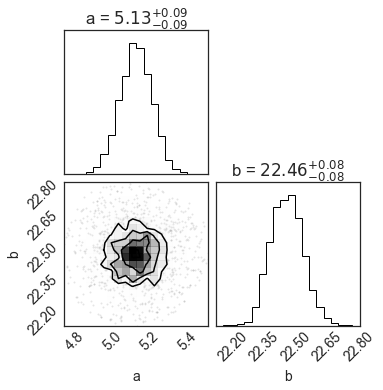

In [215]:
# Display results in cornerplot
cornerplot(result)

In [216]:
# Get results as pandas frame
df_fit = pd.DataFrame(data=result['samples'], columns=result['paramnames'])
df_fit.describe()

# Extract the fit parameters
a_fit = (np.mean(df_fit['a']), np.std(df_fit['a']))
b_fit = (np.mean(df_fit['b']), np.std(df_fit['b']))
print(f'a is: {a_fit[0]:.4f} +/- {a_fit[1]:.4f}')
print(f'b is: {b_fit[0]:.4f} +/- {b_fit[1]:.4f}')

a is: 5.1255 +/- 0.0864
b is: 22.4570 +/- 0.0764


In [217]:
N_bins = 50
chi2, prob, binwidth = aas.chi2_hist(data, pdf, [a_fit[0], b_fit[0]], N_bins)

The Chi2 is: 31.6413 with a p-value of: 0.9670


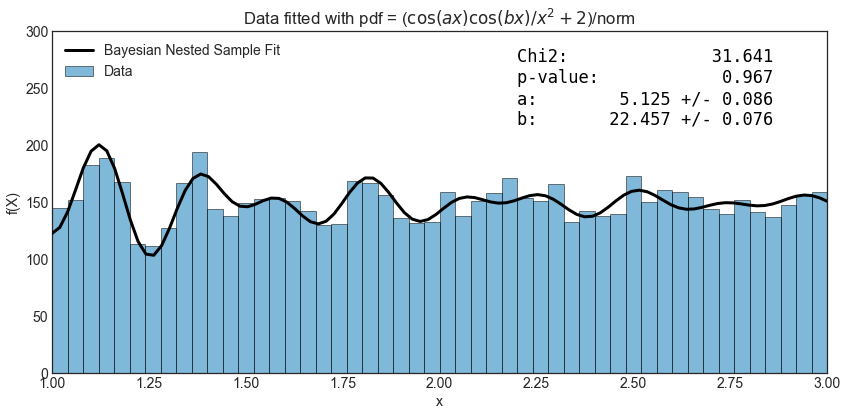

In [218]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.hist(data, N_bins, alpha=0.5, ec='k', zorder=2, label='Data')

# Plot the fit
y_arr = pdf(x_arr, a_fit[0], b_fit[0]) * len(data) * binwidth 
ax.plot(x_arr, y_arr, color='k', linewidth=3, zorder=3, label='Bayesian Nested Sample Fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2:': chi2,
     r'p-value:': prob,
     r'a:': f'{a_fit[0]:.3f} +/- {a_fit[1]:.3f}',
     r'b:': f'{b_fit[0]:.3f} +/- {b_fit[1]:.3f}',
    }

text = aas.nice_string_output(d, extra_spacing=1, decimals=3)
aas.add_text_to_ax(0.60, 0.95, text, ax, fontsize=17, color='k')

# Make pretty
ax.legend(loc='upper left')
ax.set(title=r'Data fitted with pdf = ($\cos(ax)\cos(bx)/x^2+2$)/norm', xlabel='x', ylabel='f(X)', xlim=(xlim[0], xlim[1]), ylim=(0,300))

plt.tight_layout();

if SaveFig:
    plt.savefig('Figs/3_3.pdf')
    



In [219]:
# Define ln-likelihood function
def ln_likelihood(data, pdf, parms):
    
    # Calc PDF from mass
    PDF = pdf(data, *parms)
    
    # Return log likelihood
    return np.sum(np.log(PDF)) 

# Define the function for the raster scan
def raster_2D(data, pdf, ln_likelihood, xbound, ybound, dx):
    """
    INPUTS:
    data = the data for likelihood function
    pdf = the pdf for likelihood function
    ln_likelihood = function to minimize
    xbound = bound on the first parameter
    ybound = bound on the second parameter
    dx = step size
    
    OUTPUT:
    XX = x parameter in grid shape, is a matrix
    YY = y parameter in grid shape, is a matrix
    ZZ = the target function evaluated at all combinations of parameters, is a matrix
    """
    
    # Make meshgrid for the scan
    X = np.arange(*xbound, dx)
    Y = np.arange(*ybound, dx)
    XX, YY = np.meshgrid(X,Y)
    
    # Make grids one dimensional, for easy looping
    X_values = XX.reshape(-1)
    Y_values = YY.reshape(-1)
    
    # Array to store Z values
    Z_values = np.zeros_like(X_values)
    
    # Loop over combinations
    print('----- EVALUATING TARGET FUNCTION -----')
    for i in tqdm(range(len(X_values))):
        
        # Compute Z for given X and Y
        parms = [X_values[i], Y_values[i]]
        Z_values[i] = ln_likelihood(data, pdf, parms) 
    
    # Reshape Z values back to grid shape
    ZZ = Z_values.reshape(np.shape(XX))
    
    return XX, YY, ZZ

In [220]:
# Define the range for the raster scane
a_scan_all = (0, 15)
b_scan_all = (9, 27)


a_scan = (a_fit[0]-3,a_fit[0]+3)
b_scan = (b_fit[0]-3.5,b_fit[0]+3.5)

# Define step
step_size = 0.05

# Perform raster scan
a_mat_all, b_mat_all, llh_mat_all = raster_2D(data, pdf, ln_likelihood, a_scan_all, b_scan_all, step_size)
a_mat, b_mat, llh_mat = raster_2D(data, pdf, ln_likelihood, a_scan, b_scan, step_size)

# Flip 2d arrays so (0,0) is in the bottom left corner in imshow and turn into neg llh

----- EVALUATING TARGET FUNCTION -----


  0%|          | 0/108000 [00:00<?, ?it/s]

----- EVALUATING TARGET FUNCTION -----


  0%|          | 0/16800 [00:00<?, ?it/s]

In [221]:
# Get best fit parameters
best_raster_coords_all = np.unravel_index(np.argmax(llh_mat_all, axis=None), llh_mat_all.shape)
a_rs_all = a_mat_all[best_raster_coords_all]
b_rs_all = b_mat_all[best_raster_coords_all]

best_raster_coords = np.unravel_index(np.argmax(llh_mat, axis=None), llh_mat.shape)
a_rs = a_mat[best_raster_coords]
b_rs = b_mat[best_raster_coords]

In [222]:
llh_mat_all = np.flip(llh_mat_all, axis=0)
llh_mat = np.flip(llh_mat, axis=0)

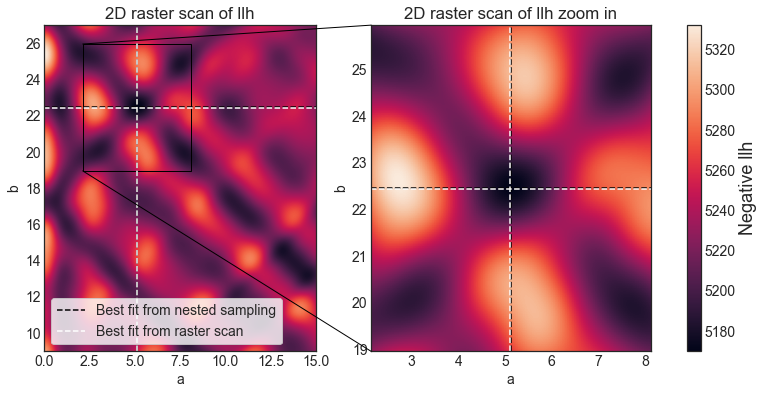

In [261]:
import matplotlib.patches as patches

fig, ax = plt.subplots(ncols=2, figsize=(17,6), gridspec_kw={'wspace':-0.4, 'width_ratios':(2,2)})

im = ax[0].imshow(-llh_mat_all, extent = [a_scan_all[0],a_scan_all[1],b_scan_all[0],b_scan_all[1]])

# Mark best fit from nested sampling
ax[0].hlines(b_fit[0], a_scan_all[0],a_scan_all[1], color='k', linestyle='dashed', label='Best fit from nested sampling')
ax[0].vlines(a_fit[0], b_scan_all[0],b_scan_all[1], color='k', linestyle='dashed')

# Mark best fit from raster scan
ax[0].hlines(b_rs_all, a_scan_all[0],a_scan_all[1], color='w', linestyle='dashed', label='Best fit from raster scan')
ax[0].vlines(a_rs_all, b_scan_all[0],b_scan_all[1], color='w', linestyle='dashed')

ax[0].legend(loc='lower left', frameon=True)
ax[0].set(title='2D raster scan of llh', xlabel='a', ylabel='b')


# zoom in
im = ax[1].imshow(-llh_mat, extent = [a_scan[0],a_scan[1],b_scan[0],b_scan[1]] )

# Colorbar -----------------
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax[1])


# Mark best fit from nested sampling
ax[1].hlines(b_fit[0], a_scan[0],a_scan[1], color='k', linestyle='dashed', label='Best fit from nested sampling')
ax[1].vlines(a_fit[0], b_scan[0],b_scan[1], color='k', linestyle='dashed')

# Mark best fit from raster scan
ax[1].hlines(b_rs_all, a_scan[0],a_scan[1], color='w', linestyle='dashed', label='Best fit from raster scan')
ax[1].vlines(a_rs_all, b_scan[0],b_scan[1], color='w', linestyle='dashed')
ax[1].set(title='2D raster scan of llh zoom in', xlabel='a', ylabel='b')


# recktangle
rect = patches.Rectangle((a_scan[0], b_scan[0]), a_scan[1]-a_scan[0], b_scan[1]-b_scan[0], linewidth=1, edgecolor='k', facecolor='none')
ax[0].add_patch(rect)

# lines
line1 = patches.ConnectionPatch(xyA=(a_scan[0],b_scan[0]), xyB=(a_scan[0],b_scan[0]), 
                                coordsA=ax[0].transData, coordsB=ax[1].transData)
line1.set_color([0, 0, 0])
fig.add_artist(line1)
line2 = patches.ConnectionPatch(xyA=(a_scan[0],b_scan[-1]), xyB=(a_scan[0],b_scan[-1]), 
                                coordsA=ax[0].transData, coordsB=ax[1].transData)
line2.set_color([0, 0, 0])
fig.add_artist(line2)

# colorbar
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = fig.colorbar(im, cax)
cbar.set_label(r'Negative llh', fontsize=18)

#if SaveFig:
#    plt.tight_layout()
#    plt.savefig('Plots/3_4.pdf')




plt.show()

In [265]:
print('Results from fit: \na =', a_fit[0],'\nb =', b_fit[0])
print('\nResults from raster scan \na =', a_rs_all,'\nb =', b_rs_all)

Results from fit: 
a = 5.125481574055412 
b = 22.457029037066132

Results from raster scan 
a = 5.1000000000000005 
b = 22.45000000000019


# Kat

In [226]:
def log_likelihood(data, pdf, pars):
    f = np.log(pdf(data, *pars))
    return -np.sum(f)

def rasterscan3(data, pdf, xrange, yrange, fig, ax, xlabel = None, ylabel = None, title = '2D Raster scan: Negative Ln-Likelihood values', delta=True, neg2log = True):

    LH_scanned = np.zeros((len(yrange),len(xrange)))
    
    for y in range(len(yrange)):
        for x in range(len(xrange)):
            LH_scanned[y,x] = log_likelihood(data, pdf, [xrange[x],yrange[y]])  
    
    max_indicies = np.unravel_index(np.argmin(LH_scanned), LH_scanned.shape)  # idx of best likelihood
    LH = LH_scanned[max_indicies]
    varx_bf = xrange[max_indicies[0]]  # best fit variable yrange
    vary_bf = yrange[max_indicies[1]]  # best fit variable xrange
    
    LH_scanned -= np.min(LH_scanned)
    LH_scanned = 2*LH_scanned
    
    ax.set(xlabel = xlabel, ylabel = ylabel, title = title)
    ax.imshow(LH_scanned)

        # ticks
    ax.set_xticks(np.arange(0,len(xrange))[::10])
    ax.set_xticklabels(np.round(xrange,2)[::10]);
    ax.tick_params(axis = 'x', rotation=-90)

    ax.set_yticks(np.arange(0,len(yrange))[::10])
    ax.set_yticklabels(np.round(yrange,2)[::10]);

    # colorbar
    im = ax.imshow(LH_scanned, vmin=np.min(LH_scanned), vmax = np.max(LH_scanned), cmap = 'ocean', alpha=0.6)
    cax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('LLH')     
    cbar.set_label('-2$\Delta$ LLH')            
    
    ax.plot(max_indicies[0],max_indicies[1],marker='*',color='m',markersize=15, ls='none',
            label = 'Best-fit value')

    ax.legend(fontsize = 16, labelcolor='white');
    
    return LH_scanned, LH, varx_bf, vary_bf, max_indicies

CPU times: user 33 s, sys: 175 ms, total: 33.2 s
Wall time: 33.2 s


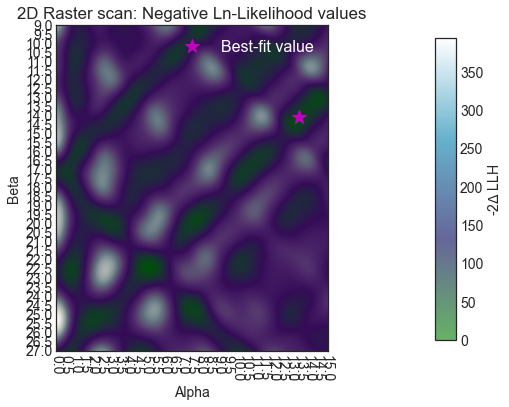

In [227]:
%%time 

a_arr = np.arange(0,15.1,0.05)
b_arr = np.arange(9,27.1,0.05)

fig3, ax3 = plt.subplots(figsize = (10,6))
_, LH, alpha_hat, beta_hat, _ = rasterscan3(data, pdf, a_arr, b_arr, fig3, ax3,
                                            xlabel = 'Alpha', ylabel = 'Beta', 
                                            title = '2D Raster scan: Negative Ln-Likelihood values')

In [228]:
alpha_hat

13.450000000000001